# Adding null component to SuSiE

Here we evaluate the possible benefit adding a null component to SuSiE. The hope is that the CS will be easier to prune (without using purity) and that the pruned CS can achieve smaller FDR.

## A simple simulation case

In [3]:
set.seed(1)
n = 500
p = 1000
b = rep(0,p)
b[200] = 1
b[800] = 1
X = matrix(rnorm(n*p),nrow=n,ncol=p)
X[,200] = X[,400]
X[,600] = X[,800]
y = X %*% b + rnorm(n)

In [4]:
diag_susie = function(purity = 0, dedup = F, ...) {
    s = susieR::susie(X, y, L=5, scaled_prior_variance=0.2, track_fit=F, coverage=NULL, ...)
    sets = susieR::susie_get_CS(s, X=cbind(X,0), coverage=0.95,min_abs_corr=purity,dedup=dedup)
    str(sets$cs)
    print('PIP for the null (1st PIP) and causal (other PIPs)')
    pip = susieR::susie_get_PIP(s, sets$cs_index)
    print(pip[c(ncol(X)+1,200,400,600,800)])
    s$sets= sets
    s$pip = pip
    print("Number of iterations")
    print(s$niter)
    return(s)
}

run_susie = function(purity = 0.1, dedup = T, ...) {
    diag_susie(purity=purity, dedup=dedup, ...)
}

### Run SuSiE in "diagnostics" mode

"Diagnostics" means that we set no purity threshold and remove no duplicate CS. The PIP computation will be based on the un-processed result.

First, fit with SuSiE as is, but over-specifiy $L$ and report all CS obtained (setting `min_abs_corr` to zero)

In [5]:
s = diag_susie()

List of 5
 $ L2: int [1:2] 600 800
 $ L1: int [1:2] 200 400
 $ L3: int [1:876] 1 2 4 5 6 8 9 10 11 12 ...
 $ L4: int [1:876] 1 2 4 5 6 8 9 10 11 12 ...
 $ L5: int [1:877] 1 2 4 5 6 8 9 10 11 12 ...
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1]        NA 0.5006026 0.5006026 0.5006017 0.5006017
[1] "Number of iterations"
[1] 7


So the 3rd and 4th CS are large. Now add a penalty to null,

As expected the CS got slightly narrower, and the PIP for the null is larger than $1/p$ (0.001 in this case). Now I increase the penalty,

In [6]:
s = diag_susie(null_weight=0.01)

List of 5
 $ L2: int [1:2] 600 800
 $ L1: int [1:2] 200 400
 $ L3: int [1:866] 1 2 4 5 6 8 9 10 11 12 ...
 $ L5: int [1:868] 1 2 4 5 6 8 9 10 11 12 ...
 $ L4: int [1:867] 1 2 4 5 6 8 9 10 11 12 ...
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 0.1886082 0.5005565 0.5005565 0.5005557 0.5005557
[1] "Number of iterations"
[1] 6


In [7]:
s = diag_susie(null_weight=0.5)

List of 5
 $ L2: int [1:2] 600 800
 $ L1: int [1:2] 200 400
 $ L4: int [1:179] 8 10 25 31 32 33 36 37 38 45 ...
 $ L3: int [1:179] 8 10 25 31 32 33 36 37 38 45 ...
 $ L5: int [1:179] 8 10 25 31 32 33 36 37 38 45 ...
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 0.9966583 0.5000714 0.5000714 0.5000713 0.5000713
[1] "Number of iterations"
[1] 4


In [8]:
s = diag_susie(null_weight=0.9)

List of 5
 $ L2: int [1:2] 600 800
 $ L3: int 1001
 $ L4: int 1001
 $ L5: int 1001
 $ L1: int [1:2] 200 400
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 0.9999901 0.5000091 0.5000091 0.5000091 0.5000091
[1] "Number of iterations"
[1] 3


In [9]:
s = diag_susie(null_weight=0.98)

List of 5
 $ L2: int [1:2] 600 800
 $ L3: int 1001
 $ L4: int 1001
 $ L5: int 1001
 $ L1: int [1:2] 200 400
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 0.9999999 0.5000017 0.5000017 0.5000017 0.5000017
[1] "Number of iterations"
[1] 3


### Run SuSiE in default mode

Here we set purity threshold to 0.1 and remove duplicate CS.

In [10]:
s = run_susie()

List of 2
 $ L2: int [1:2] 600 800
 $ L1: int [1:2] 200 400
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1]  NA 0.5 0.5 0.5 0.5
[1] "Number of iterations"
[1] 7


In this example the default SuSiE with purity filter is good enough. No need to bother with a penalty.

In [11]:
s = run_susie(null_weight=0.7)

List of 2
 $ L2: int [1:2] 600 800
 $ L1: int [1:2] 200 400
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 0.0 0.5 0.5 0.5 0.5
[1] "Number of iterations"
[1] 3


In [12]:
s = run_susie(null_weight=0.75)

List of 3
 $ L2: int [1:2] 600 800
 $ L4: int [1:2] 954 1001
 $ L1: int [1:2] 200 400
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 0.9405439 0.5000088 0.5000088 0.5000088 0.5000088
[1] "Number of iterations"
[1] 3


At least from this example, we will get stuck to a null set only when `null_weight` is very high.

## A null simulation

We simulate random data,

In [13]:
set.seed(1)
n = 500
p = 1000
X = matrix(rnorm(n*p),nrow=n,ncol=p)
y = rnorm(n)

and run SuSiE with / without purity filter:

In [14]:
s = diag_susie()

List of 5
 $ L5: int [1:887] 1 2 4 5 6 8 9 10 11 12 ...
 $ L4: int [1:887] 1 2 4 5 6 8 9 10 11 12 ...
 $ L2: int [1:887] 1 2 4 5 6 8 9 10 11 12 ...
 $ L3: int [1:887] 1 2 4 5 6 8 9 10 11 12 ...
 $ L1: int [1:887] 1 2 4 5 6 8 9 10 11 12 ...
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1]          NA 0.002444137 0.007357031 0.002841289 0.002235344
[1] "Number of iterations"
[1] 7


In [15]:
s = run_susie()

 NULL
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1]          NA 0.002444137 0.007357031 0.002841289 0.002235344
[1] "Number of iterations"
[1] 7


For this simple case, the purity filter itself is good enough to tell between signal and noise.

## A case demonstrating the usefulness of penalty

I took this data-set from our simulation. This is a case SuSiE makes false discovery in multi-signal setting.

In [16]:
%cd ../dsc/susie_comparison

/project/mstephens/SuSiE/mvarbvs/dsc/susie_comparison

In [17]:
dat = readRDS('lm_less/liter_data_4_summarize_ld_1_lm_less_3.rds')$data

In [18]:
r=1
fitted = susieR::susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.1,
               tol=1e-3, track_fit=TRUE)

In [19]:
b = dat$true_coef[,r]
b[which(b!=0)] = 1

The data is noisy,

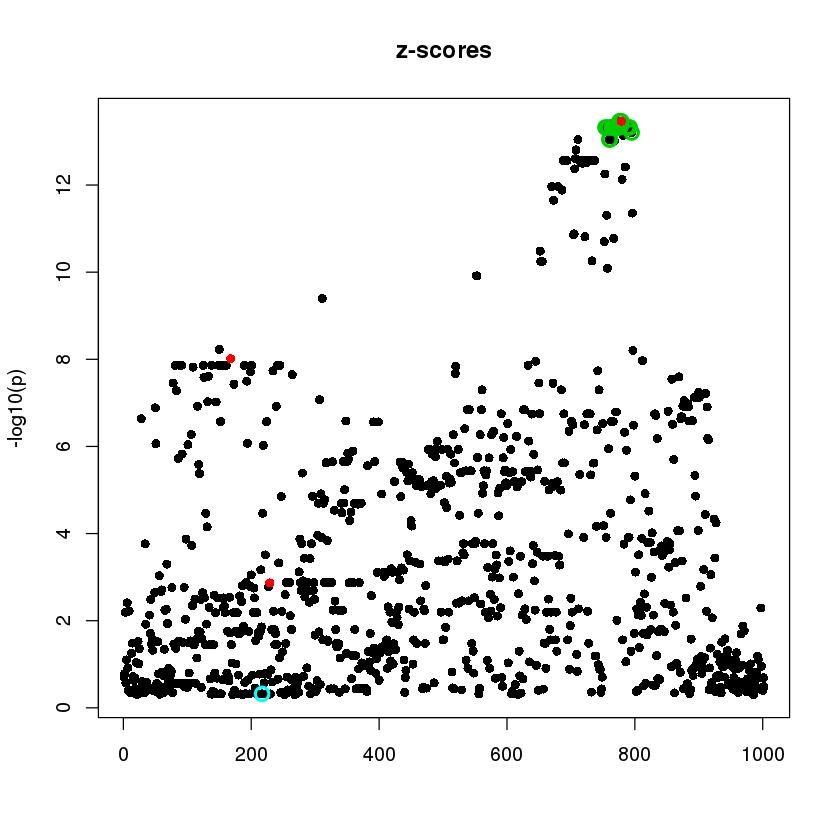

In [20]:
susieR::susie_plot(fitted, y='z', b=b, main = paste('z-scores'))

and SuSiE confidently makes a mistake,

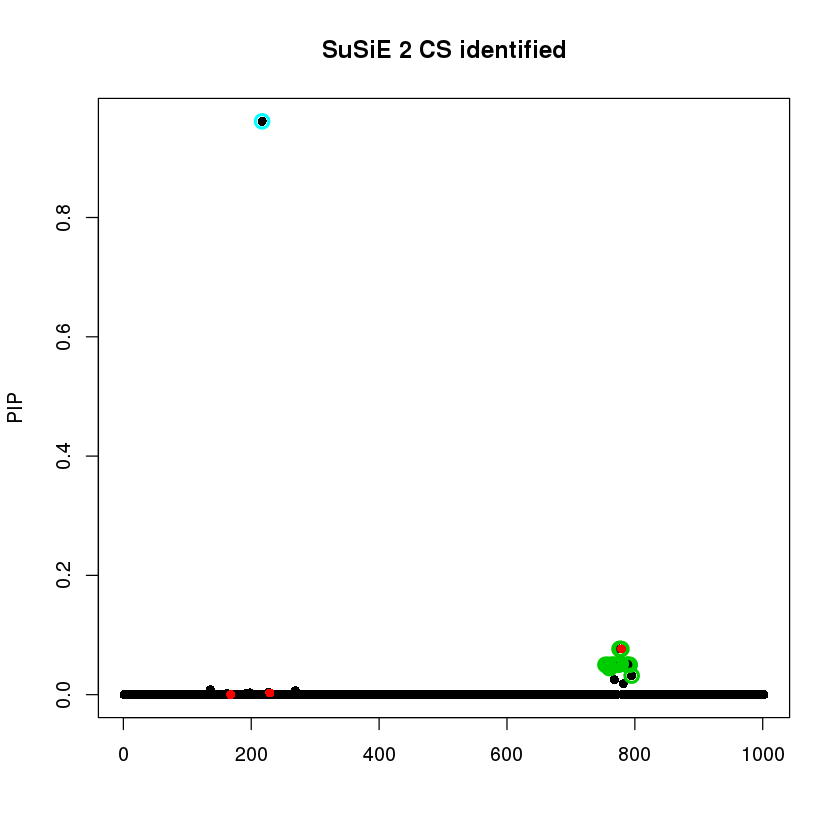

In [21]:
susieR::susie_plot(fitted, y='PIP', b=b, max_cs=0.4, main = paste('SuSiE', length(fitted$sets$cs), 'CS identified'))

Now let's run SuSiE with penalty 0.5,

In [22]:
X=dat$X
y=dat$Y[,r]
s = run_susie(null_weight=0.5)
s$sets$purity

List of 2
 $ L1: int [1:20] 754 758 760 761 764 765 768 769 773 774 ...
 $ L2: int [1:23] 217 253 317 458 477 480 487 498 512 524 ...
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 2.281939e-03 2.876166e-05 1.979294e-07 4.220626e-06 2.215953e-06
[1] "Number of iterations"
[1] 5


,min.abs.corr,mean.abs.corr,median.abs.corr
L1,0.9949778,0.9989818,0.9990075
L2,0.3050814,0.8445192,0.9015019


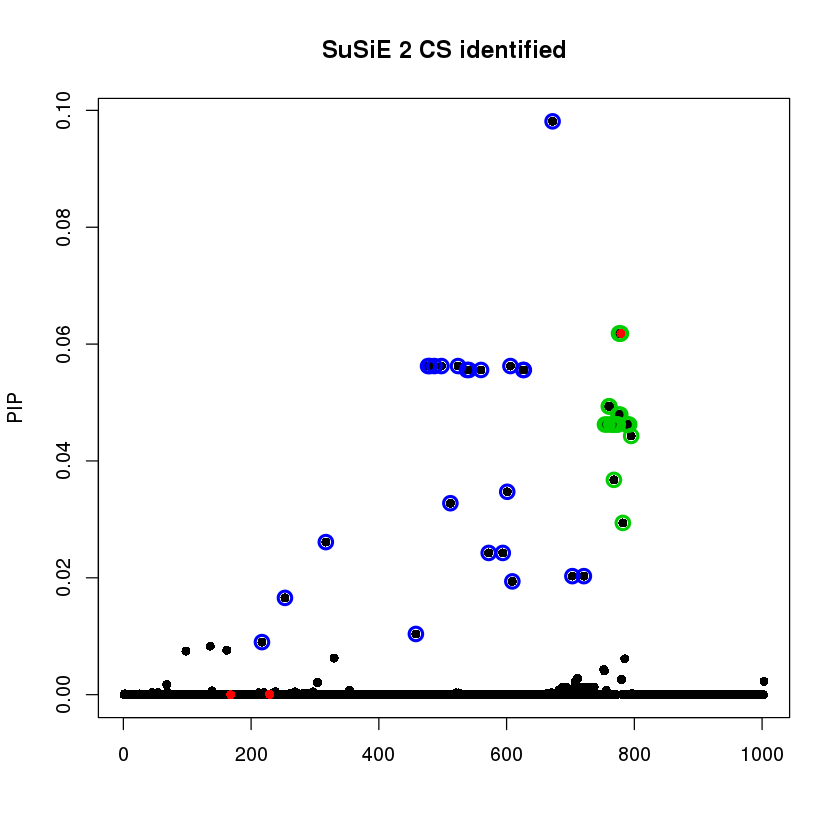

In [23]:
susieR::susie_plot(s, y='PIP', b=b, max_cs=0.1, main = paste('SuSiE', length(fitted$sets$cs), 'CS identified'))

It is not helping. Now try with 0.9,

In [24]:
s = run_susie(null_weight=0.9)
s$sets$purity

List of 3
 $ L3: int 1003
 $ L1: int [1:22] 753 754 758 760 761 764 765 768 769 773 ...
 $ L2: int [1:25] 136 162 217 253 317 477 480 487 498 512 ...
[1] "PIP for the null (1st PIP) and causal (other PIPs)"
[1] 9.724104e-01 5.771795e-05 9.608390e-06 1.430286e-05 1.157380e-05
[1] "Number of iterations"
[1] 4


,min.abs.corr,mean.abs.corr,median.abs.corr
L3,1.0000000,1.0000000,1.0000000
L1,0.9778512,0.9971642,0.9990075
L2,0.2842791,0.7665057,0.8831208


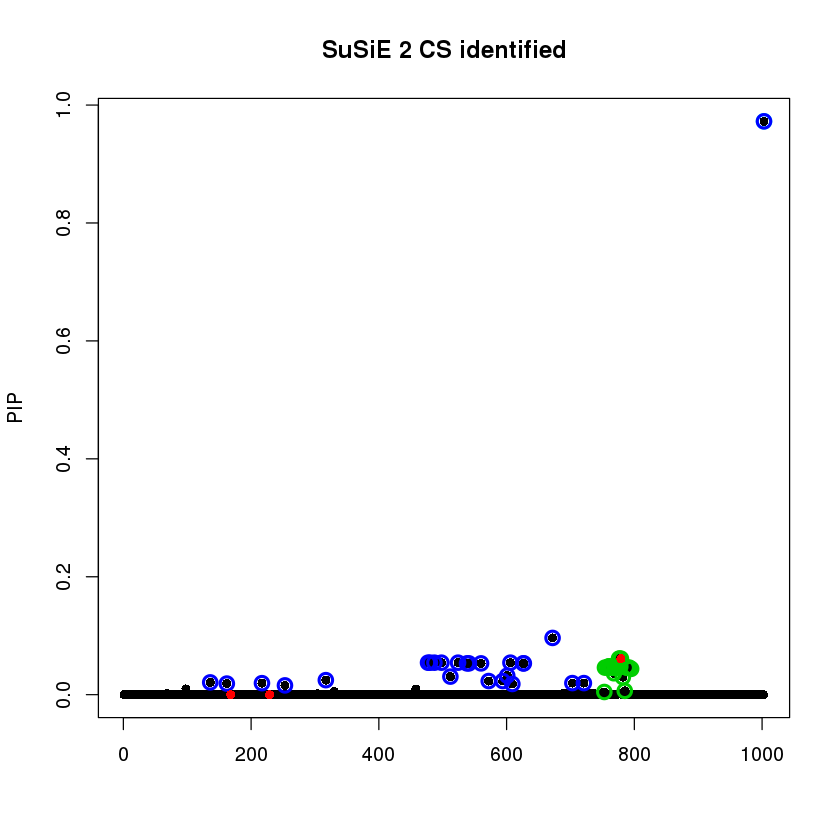

In [25]:
susieR::susie_plot(s, y='PIP', b=b, max_cs=0.1, main = paste('SuSiE', length(fitted$sets$cs), 'CS identified'))

## Another real data example

In [37]:
dat = dscrutils::load_inputs(c('lm_less/liter_data_12_summarize_ld_1_lm_less_3.pkl'), dscrutils::read_dsc)$data

In [38]:
r=1
fitted = susieR::susie(dat$X, dat$Y[,r], L=5,
               estimate_residual_variance=TRUE, 
               scaled_prior_variance=0.1,
               tol=1e-3, track_fit=TRUE)

In [39]:
b = dat$true_coef[,r]
b[which(b!=0)] = 1

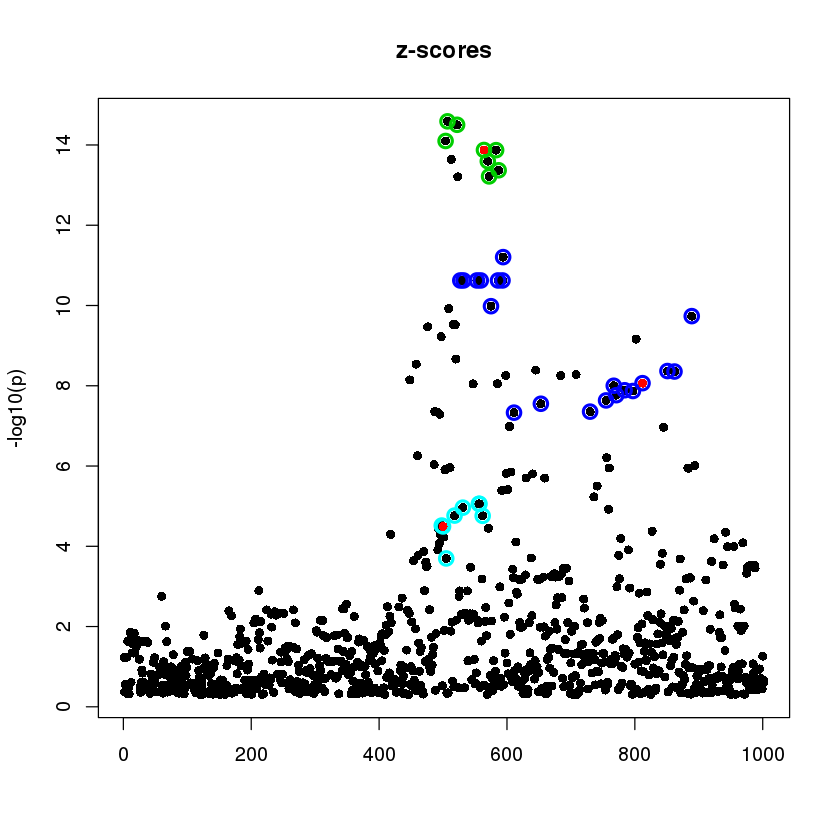

In [40]:
susieR::susie_plot(fitted, y='z', b=b, main = paste('z-scores'))

It seems fine. But previous result,

In [41]:
s = readRDS("fit_susie/liter_data_12_summarize_ld_1_lm_less_3_fit_susie_6.rds")$fitted[[r]]

In [42]:
sets = susieR::susie_get_CS(s, X=dat$X, coverage=0.95,min_abs_corr=0.1)
pip = susieR::susie_get_PIP(s, sets$cs_index)
s$sets= sets
s$pip = pip

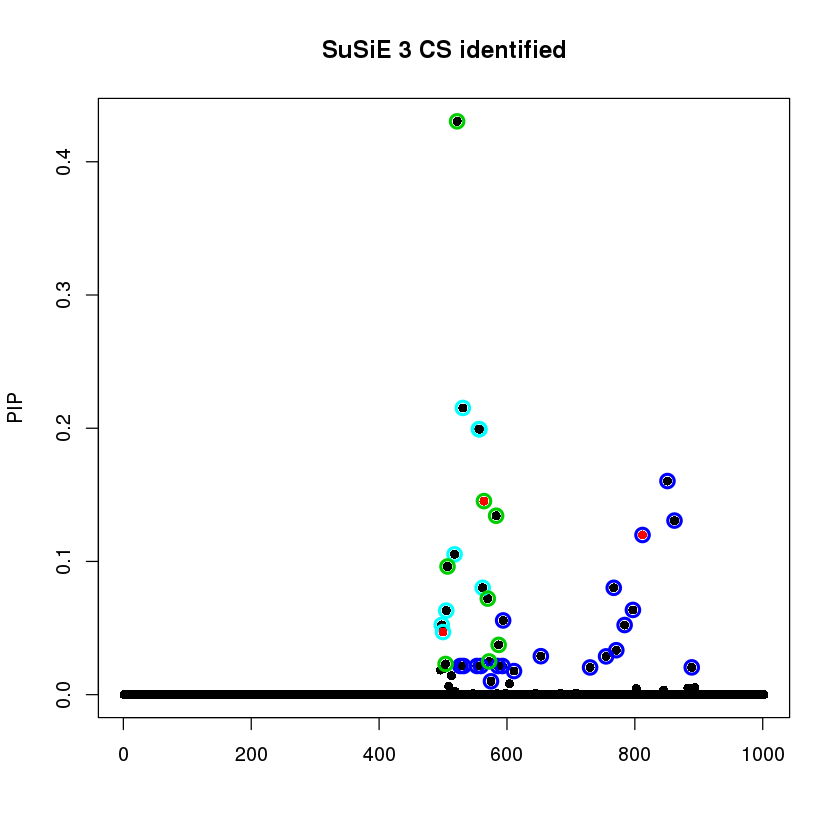

In [43]:
susieR::susie_plot(s, y='PIP', b=b, main = paste('SuSiE', length(fitted$sets$cs), 'CS identified'))

In [44]:
debug = readRDS("fit_susie/liter_data_12_summarize_ld_1_lm_less_3_fit_susie_6.rds")$DSC_DEBUG
cat(debug$script)

## r script UUID: 86257949
library(susieR)
DSC_1BF7CD6A <- list()
DSC_1BF7CD6A <- dscrutils::load_inputs(c('susie_comparison/lm_less/liter_data_12_summarize_ld_1_lm_less_3.pkl'), dscrutils::read_dsc)
DSC_REPLICATE <- DSC_1BF7CD6A$DSC_DEBUG$replicate
data <- DSC_1BF7CD6A$data
estimate_residual_variance <- TRUE
maxI <- 200
maxL <- 5
prior_var <- 0.1
TIC_1BF7CD6A <- proc.time()
set.seed(DSC_REPLICATE)

## BEGIN DSC CORE
fitted <- list()
for (r in 1:ncol(data$Y)) {
  if ('Z' %in% names(data)) {
      data$Y[,r] = residuals(lm(data$Y[,r]~Z, na.action=na.exclude))
  }
  if (prior_var == 'auto') {
      fitted[[r]] <- susieR::susie_auto(data$X,data$Y[,r],L_max=100,tol=1e-3)
  } else if (prior_var == 0) {
      fitted[[r]] <- susieR::susie(data$X,data$Y[,r],
                               L=maxL,
                               max_iter=maxI,
                               estimate_residual_variance=estimate_residual_variance,
                               estimate_prior_variance=TRUE,
       

In [36]:
print(debug$session)

 [1] "R version 3.5.1 (2018-07-02)"                                                         
 [2] "Platform: x86_64-pc-linux-gnu (64-bit)"                                               
 [3] "Running under: Scientific Linux 7.4 (Nitrogen)"                                       
 [4] ""                                                                                     
 [5] "Matrix products: default"                                                             
 [6] "BLAS/LAPACK: /software/openblas-0.2.19-el7-x86_64/lib/libopenblas_haswellp-r0.2.19.so"
 [7] ""                                                                                     
 [8] "locale:"                                                                              
 [9] " [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              "                           
[10] " [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    "                           
[11] " [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   "     